### EDA and Forecasting of Superstore Sales

This project...

#### Install and Import Libraries

In [30]:
!pip install kagglehub --q
!pip install seaborn   --q
!pip install statsmodels --q
!pip install sktime --q


[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
import kagglehub
import shutil
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
import pandas as pd
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_absolute_error, r2_score

#### Download Dataset

We download the dataset we'll be using from kaggle using the `kagglehub` library

In [32]:
path = kagglehub.dataset_download("rohitsahoo/sales-forecasting")

Since this method by default downloads files to an internal KaggleHub cache location, we'll copy them to our current location. 

In [33]:
destination = os.path.join(os.getcwd(), "./data")
os.makedirs(destination, exist_ok=True)

for filename in os.listdir(path):
    src_file = os.path.join(path, filename)
    dst_file = os.path.join(destination, filename)
    shutil.copy(src_file, dst_file)

We now read the dataset with `pandas` and we can take a look and start exploring the different fields.

In [34]:
df = pd.read_csv(os.path.join(destination, "train.csv"))
df.head(1)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96


#### Data Exploration and Cleaning

##### Preprocessing

We'll drop some irrelevant or low-impact columns for sales forecasting. These include identifiers and granular personal data that do not contribute significantly to the forecasting task.

We'll also convert the format of `Order Date` and `Ship Date` to standard datetime formats.

In [35]:
columns_to_drop = [
    'Row ID', 'Order ID', 'Ship Mode', 'Customer ID',
    'Customer Name', 'Product ID', 'Postal Code', 'Country'
    ]

df.drop(columns=columns_to_drop, inplace=True)

df['Order Date'] = pd.to_datetime(df['Order Date'], format="%d/%m/%Y")
df['Ship Date']  = pd.to_datetime(df['Ship Date'], format="%d/%m/%Y")

Now `df` is the dataframe that contains all the information about sales from a superstore in the United States, registering for each sale the date when it was ordered (`Order Date`) among other related data.

In [36]:
df.head(5)

,Order Date,Ship Date,Segment,City,State,Region,Category,Sub-Category,Product Name,Sales
0,2017-11-08,2017-11-11,Consumer,Henderson,Kentucky,South,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2017-11-08,2017-11-11,Consumer,Henderson,Kentucky,South,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,2017-06-12,2017-06-16,Corporate,Los Angeles,California,West,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,2016-10-11,2016-10-18,Consumer,Fort Lauderdale,Florida,South,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,2016-10-11,2016-10-18,Consumer,Fort Lauderdale,Florida,South,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


We will create separate datasets for each region to identify the sales trends on each (if any).

In [37]:
central = df[df['Region'] == 'Central']
east    = df[df['Region'] == 'East']
south   = df[df['Region'] == 'South']
west    = df[df['Region'] == 'West']

We now make the necessary convertions so we have an overall monthly sales df and also by region monthly sales df.

To achieve this we group `Sales` by `Order Date`, then sort according to `Order Date` and finally resample this same column so it's in year-month format.

In [38]:
all_daily   = df.groupby('Order Date')['Sales'].sum().reset_index()
all_daily   = all_daily.sort_values('Order Date')
all_monthly = all_daily.set_index('Order Date').resample('ME').mean()

central_daily   = central.groupby('Order Date')['Sales'].sum().reset_index()
central_daily   = central_daily.sort_values('Order Date')
central_monthly = central_daily.set_index('Order Date').resample('ME').mean()

east_daily   = east.groupby('Order Date')['Sales'].sum().reset_index()
east_daily   = east_daily.sort_values('Order Date')
east_monthly = east_daily.set_index('Order Date').resample('ME').mean()

south_daily   = south.groupby('Order Date')['Sales'].sum().reset_index()
south_daily   = south_daily.sort_values('Order Date')
south_monthly = south_daily.set_index('Order Date').resample('ME').mean()

west_daily   = west.groupby('Order Date')['Sales'].sum().reset_index()
west_daily   = west_daily.sort_values('Order Date')
west_monthly = west_daily.set_index('Order Date').resample('ME').mean()

##### Descriptive Statistics

We'll use the `describe` method from pandas to retrieve a summary statistic that describes our dataset a little bit, including **mean** (measure of central tendency), **standard deviation** (measure of dispersion), **percentiles** and **maximum** and **minimum** of the distribution.

In [39]:
all_monthly.describe()

,Sales
count,48.000000
mean,1775.061941
std,812.454746
min,225.994600
25%,1124.826076
50%,1539.262281
75%,2443.701486
max,3931.271833


##### Time Plot

Daily.

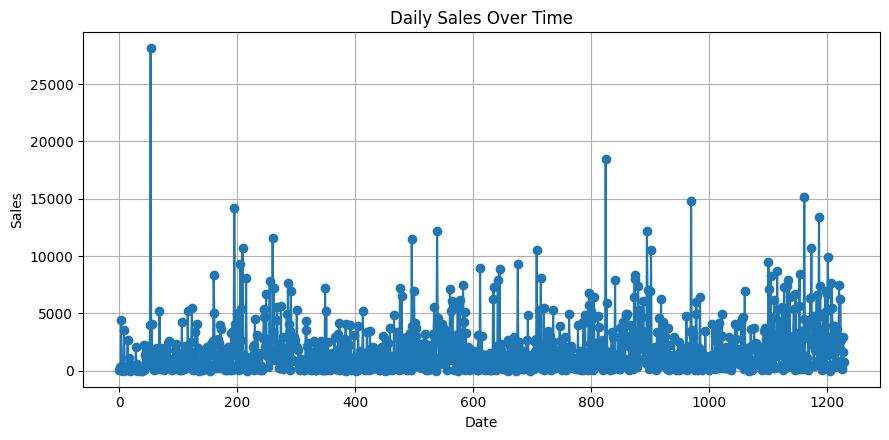

In [40]:
plt.figure(figsize=(9, 4.5))
plt.plot(all_daily.index, all_daily['Sales'], marker='o')
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

Monthly. This plot itself provides several information! As we could expect, the pattern shows some yearly seasonality and an increasing trend over the years.

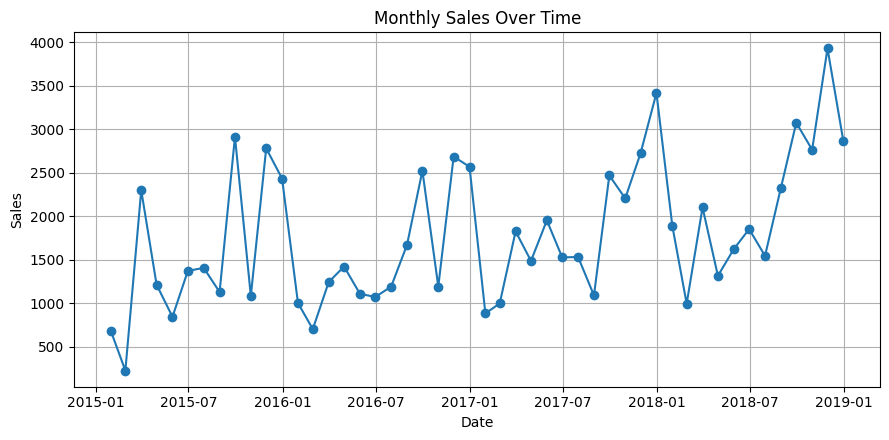

In [41]:
plt.figure(figsize=(9, 4.5))
plt.plot(all_monthly.index, all_monthly['Sales'], marker='o')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.grid(True)
plt.show()

Yearly. This plot shows us an evident increasing trend.

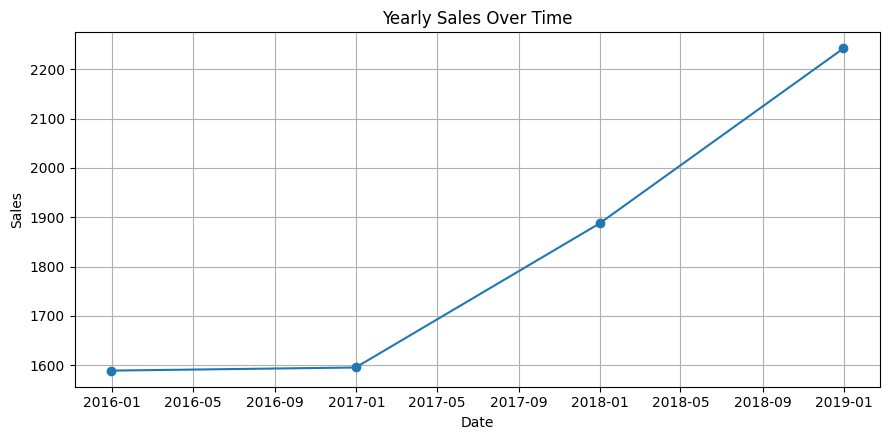

In [42]:
all_yearly = all_daily.set_index('Order Date').resample('YE').mean()

plt.figure(figsize=(9, 4.5))
plt.plot(all_yearly.index, all_yearly['Sales'], marker='o')
plt.title('Yearly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.grid(True)
plt.show()

To make it more interesting, we'll also take a look into the monthly sales by region!

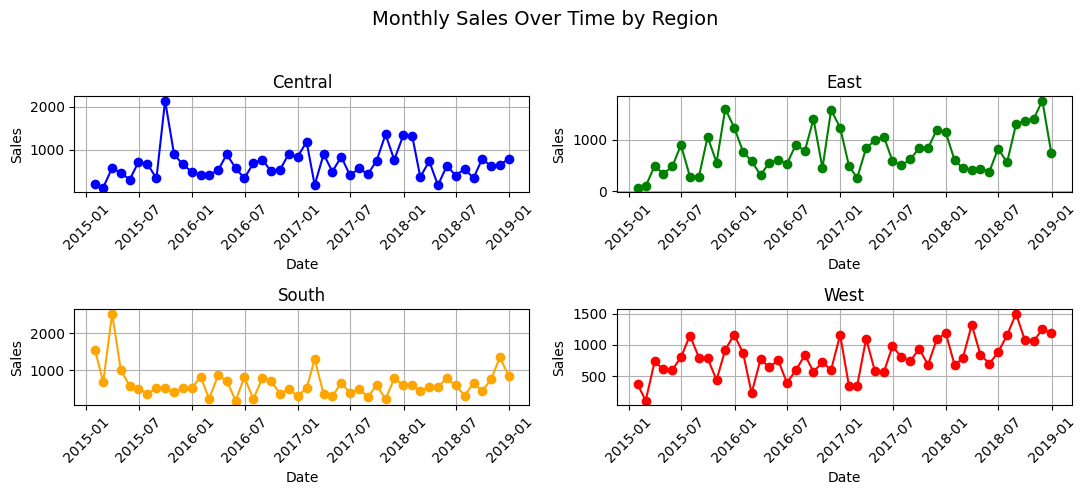

In [43]:
fig, axs = plt.subplots(2, 2, figsize=(11, 5))
fig.suptitle('Monthly Sales Over Time by Region', fontsize=14)

axs[0, 0].plot(central_monthly.index, central_monthly['Sales'], color='blue', marker='o')
axs[0, 0].set_title('Central')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Sales')
axs[0, 0].grid(True)

axs[0, 1].plot(east_monthly.index, east_monthly['Sales'], color='green', marker='o')
axs[0, 1].set_title('East')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Sales')
axs[0, 1].grid(True)

axs[1, 0].plot(south_monthly.index, south_monthly['Sales'], color='orange', marker='o')
axs[1, 0].set_title('South')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Sales')
axs[1, 0].grid(True)

axs[1, 1].plot(west_monthly.index, west_monthly['Sales'], color='red', marker='o')
axs[1, 1].set_title('West')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Sales')
axs[1, 1].grid(True)

for ax in axs.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

##### Seasonal Decomposition

As time series data can exhibit various of patterns, it's quite helpful to split a time series into components, each representing an underlying pattern category.

We'll use `seasonal_decompose` from statsmodel library, which allow us to split a time series in three components: **trend**, **seasonal** and **remainder** components.

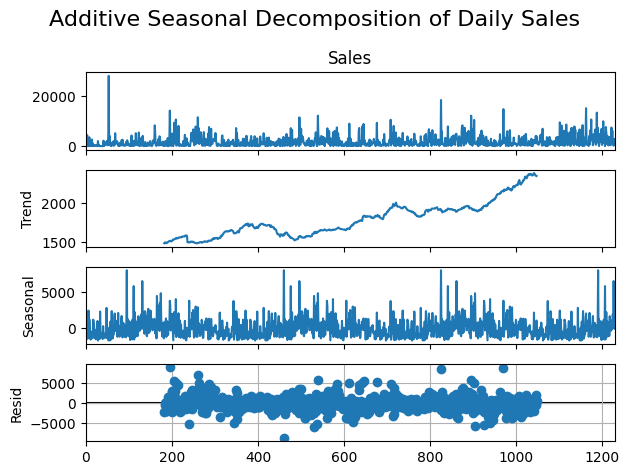

In [44]:
result = seasonal_decompose(all_daily['Sales'], model='additive', period=365)
result.plot()
plt.suptitle('Additive Seasonal Decomposition of Daily Sales', fontsize=16)
plt.tight_layout()
plt.grid(True)
plt.show()

Monthly. Here we can see a strong seasonal component, not observed on the daily and yearly decompositions, as well as a growing trend (across daily, monthly and yearly).

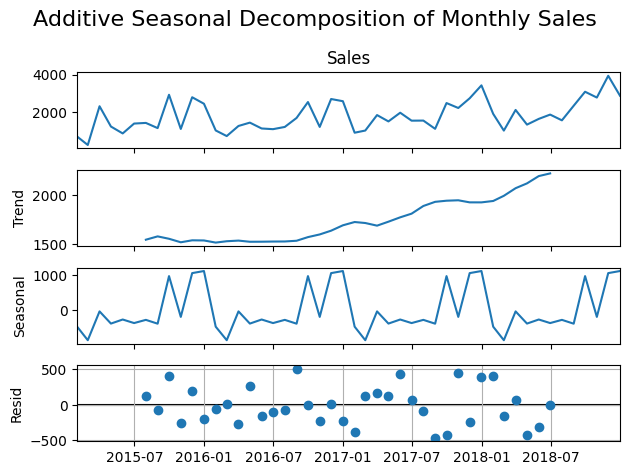

In [45]:
result = seasonal_decompose(all_monthly['Sales'], model='additive')
result.plot()
plt.suptitle('Additive Seasonal Decomposition of Monthly Sales', fontsize=16)
plt.tight_layout()
plt.grid(True)
plt.show()

Yearly.

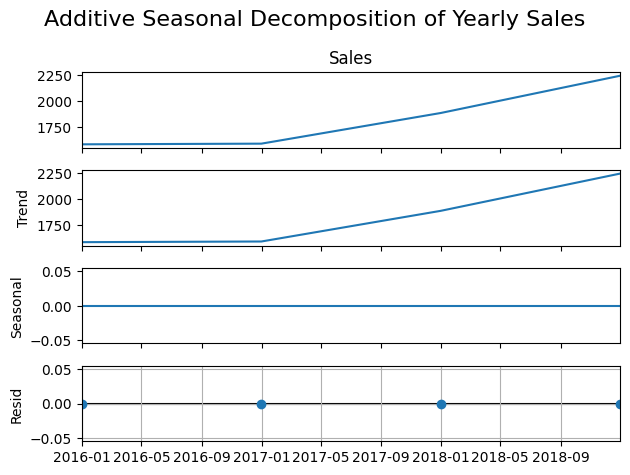

In [46]:
result = seasonal_decompose(all_yearly['Sales'], model='additive')
result.plot()
plt.suptitle('Additive Seasonal Decomposition of Yearly Sales', fontsize=16)
plt.tight_layout()
plt.grid(True)
plt.show()

#### Forecasting

##### Theta Forecaster

We take the `Sales` column of the all_monthly dataframe, and then change the index so it is in a monthly PeriodIndex format starting on January 2014. This is needed so that the sktime forecasting model we are using understands the data and applies the seasonality correctly.

In [47]:
y = all_monthly['Sales']
y.index = pd.period_range(start='2014-01', periods=len(y), freq='M')

We split the time series in training (`y_train`) and testing (`y_test`), respecting the temporal order and not at random (or some kind of random) like ML and DL, and also define the "forecasting horizon", which is the dates we want to predict sales for, this being the ones on `y_test`. 

In [48]:
y_train, y_test = temporal_train_test_split(y)
horizon = ForecastingHorizon(y_test.index, is_relative=False)

We create an instance of the Theta Forecaster model, and we use a seasonality of 12 periods (months) and then train it using the training data, which allows the model to learn the trend and seasonal pattern. After this, we make predictions for the forecasting horizon and lastly plot the full time series and the prediction to see how did the model do.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Theta Forecaster'}, ylabel='Sales'>)

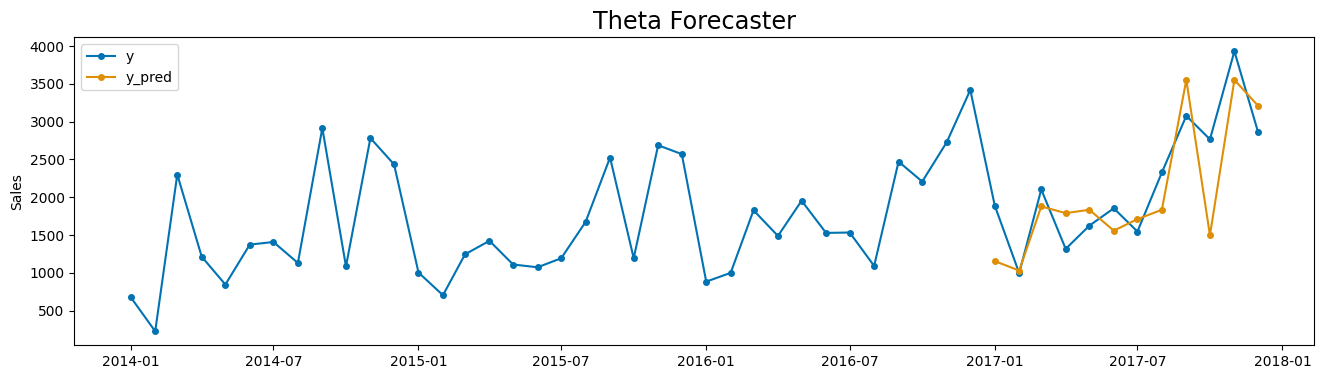

In [49]:
forecasting_model = ThetaForecaster(sp=12)
forecasting_model.fit(y_train)
y_pred = forecasting_model.predict(horizon)
plot_series(y, y_pred, title='Theta Forecaster', labels=['y','y_pred'])

We also calculate some metrics to have a cuantitative notion besides the plot itself.

In [50]:
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape*100:.2f}%")
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE : {mae:.2f}")
r2 = r2_score(y_test, y_pred)   
print(f"R2  : {r2:.2f}")

MAPE: 19.40%
MAE : 425.17
R2  : 0.57


The Theta Forecaster achieved a moderate forecasting performance on the monthly sales data we used. With a MAPE of 19.40%, the model's predictions deviate by about 19% from the actual values on average, which is sort of acceptable given the high variability observed in the dataset.

The Mean Absolute Error (MAE) of 425.17 indicates that, in absolute terms, predictions are off by around 425 on average, 23.9% of the average monthly sales (1775 according to `describe()` pandas function).

Additionally, the model explains 57% of the variance (coefficient of determination R² = 0.57) in the sales series, which suggests that it captures some meaningful patterns, though a significant portion of variability remains unexplained.

Given the relatively high standard deviation and wide sales range, the current results are a reasonable starting point. However, there's clear room for improvement, possibly through the use of more advanced models, which we'll do in the following sections.